In [62]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML # rendering animations
from tqdm import tqdm
import xarray as xr 
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
from scipy import signal

In [2]:
small_action_dict = {
    0: {"name":"Up", "label":"↑", "delta":(0,1)},
    1: {"name":"Right", "label":"→", "delta":(1,0)},
    2: {"name":"Down", "label":"↓", "delta":(0,-1)},
    3: {"name":"Left", "label":"←", "delta":(-1,0)},}

In [3]:
def format_axes(ax, xlims=None, ylims=None):
    """
    Format the axes by removing top and right spines, setting the bounds of the left and bottom spines,
    and setting the x and y limits if provided.
    
    Parameters:
    - ax: The axes object to format.
    - xlims: The x-axis limits as a tuple (min, max). If None, the limits are determined from the data.
    - ylims: The y-axis limits as a tuple (min, max). If None, the limits are determined from the data.
    
    Returns:
    - The formatted axes object.
    """
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # xlims = (xlims or (ax.dataLim.bounds[0], ax.dataLim.bounds[2]))
    # ylims = (ylims or (ax.dataLim.bounds[1], ax.dataLim.bounds[3]))
    # ax.spines['left'].set_bounds(ylims[0], ylims[1])
    # ax.spines['bottom'].set_bounds(xlims[0], xlims[1])
    return ax

In [4]:
def epsilon_greedy_policy(Q_value_function, state, n_actions, epsilon=0.1):
    """
    Epsilon-greedy policy for choosing actions.

    Parameters:
    - Q_value_function : function
        A function that computes Q-values, e.g., tdqlearner.Q_value.
    - state : int
        The current state.
    - n_actions : int
        The number of possible actions.
    - epsilon : float
        The probability of choosing a random action (exploration).

    Returns:
    - int: The chosen action.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)  # Random action
    else:
        q_values = [Q_value_function(state, a) for a in range(n_actions)]
        return np.argmax(q_values)  # Greedy action

In [ ]:
class QLearnerAgent():
    def __init__(self, gamma=0.5, alpha=0.1, n_features=10, n_actions=2):
        self.theta = np.zeros((n_features, n_actions))  # Linear Q-function parameters
        self.n_actions = n_actions
        self.n_features = n_features
        self.gamma = gamma
        self.alpha = alpha
        
    def get_features(self, S, A):
        features = np.zeros(self.n_features)
        if S is not None:
            features[S] = 1  # Set the feature corresponding to the state S to 1
        return features

    
    def Q_value(self, S, A):
        # Compute Q(s, a) = theta^T * phi(s, a)
        features = self.get_features(S, A)
        return np.dot(self.theta[:, A], features)

    def learn(self, S, S_next, A, A_next, R):
        # Get the current Q-value
        Q = 0 if S is None else self.Q_value(S, A)

        # Get the next Q-value
        Q_next = 0 if S_next is None else self.Q_value(S_next, A_next)

        # Calculate the TD error
        TD_error = R + self.gamma * Q_next - Q

        # Update the parameters using gradient descent
        if S is not None:
            features = self.get_features(S, A)
            self.theta[:, A] += self.alpha * TD_error * features

        return TD_error

In [ ]:
class MiniGrid():
    """
    Represents a grid environment for reinforcement learning.

    Parameters:
    - grid : np.ndarray, optional
        The grid representation of the environment.
    - reward_locations : list, optional
        The locations of the rewards in the grid. Default is [(5,5)].
    - reward_values : list, optional
        The values of the rewards. Default is [10].
    - max_steps : int, optional
        The maximum number of steps allowed in an episode. Default is 100.
    - action_dict : dict, optional
        A dictionary mapping action indices to action labels. Default is small_action_dict.
    - cost_per_step : float, optional
        The cost incurred per step. Default is 0.1.
    - cost_per_wall_collision : float, optional
        The cost incurred per wall collision. Default is 1.
    """

    def __init__(
        self,
        grid : np.ndarray = None,
        pk_hw = 2,
        reward_locations : list = [(5,5)],
        reward_values : list = [10],
        max_steps = 100,
        action_dict = small_action_dict, 
        cost_per_step = 0.1,
        cost_per_wall_collision = 1,
    ):
        """
        Initializes the MiniGrid environment.

        Parameters:
        - grid : np.ndarray, optional
            The grid representation of the environment. 
        - reward_locations : list, optional
            The locations of the rewards in the grid. Default is [(5,5)].
        - reward_values : list, optional
            The values of the rewards. Default is [10].
        - max_steps : int, optional
            The maximum number of steps allowed in an episode. Default is 100.
        - action_dict : dict, optional
            A dictionary mapping action indices to action labels. Default is small_action_dict.
        - cost_per_step : float, optional
            The cost incurred per step. Default is 0.1.
        - cost_per_wall_collision : float, optional
            The cost incurred per wall collision. Default is 1.
        """
        
        if grid is not None:
            self.grid = grid
            self.width = grid.shape[1]
            self.height = grid.shape[0]
            self.x_coords = np.arange(self.width)
            self.y_coords = np.arange(self.height)[::-1]
            self.grid_shape = (self.height, self.width)
            self.n_states = self.width * self.height
            self.pk_hw = pk_hw
        
        self.reward_locations = reward_locations
        self.reward_values = reward_values
        assert len(reward_locations) == len(reward_values), "Reward locations and values must be the same length"

        self.cost_per_step = cost_per_step
        self.cost_per_wall_collision = cost_per_wall_collision
        self.max_steps = max_steps
        self.reward_extent = 1 #effective size of reward is 1 (1 grid)
        self.agent_extent = 1 #effective size of agent is 1 (1 grid)
        self.episode_number = 0 
        self.recent_episode_length = self.max_steps
        self.episode_history = {}
        self.av_time_per_episode = self.max_steps
        self.episode_lengths = []

        self.action_dict = action_dict
        self.n_actions = len(self.action_dict)

        self.reset()

    def step(self, action):
        """
        Takes a step in the environment based on the given action.

        Parameters:
        - action : int
            The index of the action to take.
        """
        if action == 0:
            step_arr = np.array((0, 1)) # Up
        elif action == 1:
            step_arr = np.array((1, 0)) # Right
        elif action == 2:
            step_arr = np.array((0, -1)) # Down
        elif action == 3:
            step_arr = np.array((-1, 0)) # Left

        # Propose a new position based on the action
        proposed_new_pos = tuple(np.array(self.agent_pos) + step_arr)

        # Check if the new position is a wall or reward
        is_wall = self.is_wall(proposed_new_pos) # returns True if the proposed new position is a wall
        if not is_wall:
            self.agent_pos = proposed_new_pos
            self.agent_direction = action

        # Check if the new position is a reward
        reward = self.get_reward(proposed_new_pos) # returns any reward found at the proposed new position
        is_terminal = (reward > 0) # If a reward is found then the episode is over
        reward -= self.cost_per_step # consider adding other contributions to the reward from moving costs or hitting walls
        if is_wall:
            reward -= self.cost_per_wall_collision

        # Get the new state
        state = self.pos_to_state(self.agent_pos)

        return state, reward, is_terminal
    
    def train(self, tdqlearner, n_episodes=1000, max_episode_length=100, policy=epsilon_greedy_policy,):

        for i in (pbar := tqdm(range(n_episodes))):

            try: # this just allows you to stop the loop by pressing the stop button in the notebook

                # Initialise an episode:
                terminal = False
                self.reset() # reset the environment
                state = self.pos_to_state(self.agent_pos)
                action = policy(tdqlearner.Q_value, state)

                episode_data = {'positions': [], 'states':[], 'actions':[], 'rewards':[]}
    
                step = 0
                while not terminal and step < max_episode_length:
                    # Get the next state and reward using the step() method
                    state_next, reward, terminal = self.step(action)
                    
                    if terminal:
                        state_next = None
                        next_action = None
                    else:
                        # Get the next action using the policy() function
                        next_action = policy(tdqlearner.Q_value, state_next)

                    # Learn from the transition using the tdqlearner.learn() method
                    tdqlearner.learn(S = state, S_next = state_next, A = action, A_next = next_action, R=reward)

                    # store the data
                    episode_data['positions'].append(self.agent_pos)
                    episode_data['states'].append(state)
                    episode_data['actions'].append(action)
                    episode_data['rewards'].append(reward)

                    # update the state and action
                    state = state_next
                    action = next_action 
                    step += 1

                self.episode_history[self.episode_number] = episode_data
                self.episode_number += 1
                self.episode_lengths.append(step)

            except KeyboardInterrupt:
                break

    def reset(self):
        """
        Resets the environment by placing the agent at a random position and direction.
        """
        # is_illegal_position = True
        # while is_illegal_position:
        #     self.agent_pos = (np.random.randint(self.width), np.random.randint(self.height))
        #     is_illegal_position = self.is_wall(self.agent_pos)
        # self.agent_direction = np.random.randint(self.n_actions)

        self.agent_pos = (self.width // 2, self.height // 2)
        self.agent_direction = np.random.randint(self.n_actions)
        
    def is_wall(self, pos : tuple): 
        """
        Checks if the given position is a wall.

        Parameters:
        - pos : tuple
            The position to check.

        Returns:
        - bool: True if the position is a wall, False otherwise.
        """
        (x, y) = pos
        # print(f'pos {pos}')
        # print(f'height {self.height}')
        # print(f'self.height - 1 - y = {self.height - 1 - y}')
        
        val_at_pos = self.grid[self.height - 1 - y, x] # y is flipped because of the way the grid is plotted
        val_at_pos = 1 if val_at_pos == 0 else 0
        return val_at_pos
        # return self.grid[self.height - 1 - y, x] # y is flipped because of the way the grid is plotted
        
    def get_reward(self, pos : tuple):
        """
        Gets the reward value at the given position.

        Parameters:
        - pos : tuple
            The position to get the reward value for.

        Returns:
        - float: The reward value at the given position.
        """
        if pos in self.reward_locations:
            return self.reward_values[self.reward_locations.index(pos)]
        else:
            return 0
    
    def plot_episode(self, episode_number=None, ax=None, stop_at_step=None):
        """
        Plots the trajectory of an episode.

        Parameters:
        - episode_number : int, optional
            The episode number to plot. If not provided, the most recent episode will be plotted.
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.
        - stop_at_step : int, optional
            The step at which to stop plotting. If not provided, the entire episode will be plotted.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if episode_number is None:
            episode_number = self.episode_number - 1
        else: 
            episode_number = np.arange(self.episode_number)[episode_number]
        episode_data = self.episode_history[episode_number]
        positions = episode_data["positions"]
        actions = episode_data["actions"]
        if ax is None:
            ax = self._plot_env(ax=ax)
            ax = self._plot_rewards(ax)
        if stop_at_step is None: stop_at_step = len(positions)
        for i in range(stop_at_step):
            episode_frac = i/len(positions)
            ax = self._plot_agent(agent_pos=positions[i], agent_direction=actions[i], ax=ax, color = plt.cm.viridis(1-episode_frac), size_scaler=(1+episode_frac)/2, alpha = (1+episode_frac)/2)
            if i > 0:
                ax.plot([positions[i-1][0], positions[i][0]], [positions[i-1][1], positions[i][1]], color=plt.cm.viridis(1-episode_frac), alpha = (1+episode_frac)/2, linewidth=0.5)
        
        return ax
    
    def plot_Q(self, tdqlearner):
        """
        Plots the Q-values of the environment.

        Parameters:
        - tdqlearner : TDQLearner
            The learner object that contains the learned Q-function parameters.

        Returns:
        - list: The list of axes objects containing the plots.
        """
        assert (tdqlearner.theta.shape == (self.n_states, self.n_actions)), \
            f"Q_values must be of shape (n_states, n_actions) = ({self.n_states}, {self.n_actions}) but got {tdqlearner.theta.shape}"
        
        # Reshape Q_values into the grid shape
        Q_values_grid = tdqlearner.theta.reshape(self.grid_shape[0], self.grid_shape[1], self.n_actions)

        min_Q = np.min(tdqlearner.theta)
        max_Q = np.max(tdqlearner.theta)

        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(3, 3, hspace=0.4, wspace=0.4)
        
        axN = fig.add_subplot(gs[0, 1])
        axW = fig.add_subplot(gs[1, 0])
        axE = fig.add_subplot(gs[1, 2])
        axS = fig.add_subplot(gs[2, 1])
        axC = fig.add_subplot(gs[1, 1])
        
        axs = [axN, axE, axS, axW, axC]

        for i in range(self.n_actions):
            # Plot the environment and rewards
            axs[i] = self._plot_env(ax=axs[i])
            axs[i] = self._plot_rewards(ax=axs[i])
            
            # Plot the Q-values as heatmap
            axs[i].imshow(Q_values_grid[:, :, i], cmap="viridis", extent=[-0.5, self.width-0.5, -0.5, self.height-0.5], 
                        alpha=0.8, vmax=max_Q, vmin=min_Q)
            
            # Set the title using the action dictionary
            axs[i].set_title(f"Q(s,{self.action_dict[i]['label']})", color=plt.cm.twilight(i / self.n_actions))
            
            # Remove ticks and labels for better clarity
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False)
            axs[i].spines['bottom'].set_visible(False)

        # Plot the policy in the central plot
        axC = self._plot_env(ax=axC)
        axC = self._plot_rewards(ax=axC)
        axC = self.plot_policy(tdqlearner, ax=axC)
        axC.set_title("π(s)", fontsize=14)
        axC.set_xticks([])
        axC.set_yticks([])
        axC.spines['top'].set_visible(False)
        axC.spines['right'].set_visible(False)
        axC.spines['left'].set_visible(False)
        axC.spines['bottom'].set_visible(False)

        plt.tight_layout()
        plt.show()

        return axs                                     
    
    def plot_training(self, ax=None):
        """
        Plots the training progress.

        Parameters:
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        episode_lengths = np.array(self.episode_lengths)
        n_eps = len(episode_lengths)
        smoothed_episode_lengths = [np.mean(episode_lengths[max(0, i - 100):i + 1]) for i in range(n_eps)]
        ax.scatter(np.arange(self.episode_number), episode_lengths, linewidth=0, alpha=0.5, c='C0', label="Episode length")
        ax.plot(np.arange(len(smoothed_episode_lengths)), smoothed_episode_lengths, color='k', linestyle="--", linewidth=0.5, label="Smoothed")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Length")
        ax.legend()
        ax.set_title("Training Progress")
        return ax
    
    def render(self, ax=None):
        """
        Renders the current state of the environment.

        Parameters:
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        ax = self._plot_env(ax=ax)
        ax = self._plot_agent(ax=ax,agent_pos=self.agent_pos, agent_direction=self.agent_direction)
        ax = self._plot_rewards(ax)
        return ax 

    def plot_first_and_last_5_episodes(self):
        """
        Plots the trajectories of the first and last 5 episodes.

        Returns:
        - numpy.ndarray: The array of axes objects containing the plots.
        """
        fig, ax = plt.subplots(2,5, figsize=(10,4))
        for i in range(5):

            ax[0,i] = self._plot_env(ax=ax[0,i])
            ax[1,i] = self._plot_env(ax=ax[1,i])
            ax[0,i] = self._plot_rewards(ax=ax[0,i])
            ax[1,i] = self._plot_rewards(ax=ax[1,i])
        
            self.plot_episode(i, ax=ax[0,i])
            self.plot_episode(-i-1, ax=ax[1,i])
            if i == 2: 
                ax[0,i].set_title("First 5 episodes")
                ax[1,i].set_title("Last 5 episodes")
        return ax
    
    def _plot_env(self, ax=None):
        """
        Plots the environment grid.

        Parameters:
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(0.1*self.width, 0.1*self.height))

        im = ax.imshow(1 - self.grid, clim=[0.1,1.0], cmap=cm.binary, zorder=1, alpha=0.25, extent=[-0.5, self.width-0.5, -0.5, self.height-0.5])

        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xlim([self.pk_hw - 1, self.width - self.pk_hw])
        ax.set_ylim([self.pk_hw - 1, self.height - self.pk_hw])
        return ax 
    
    def _plot_rewards(self, ax, **kwargs):
        """
        Plots the rewards in the environment.

        Parameters:
        - ax : matplotlib.axes.Axes
            The axes to plot on.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        for (i,reward) in enumerate(self.reward_locations):
            reward_value = self.reward_values[i]
            max_rv, min_rv = np.max(self.reward_values), np.min(self.reward_values)
            # color = plt.colormaps['plasma']((reward_value - min_rv) / max(1, max_rv - min_rv))
            reward_patch = plt.Circle(reward, self.reward_extent * (0.4 + 0.3*((reward_value - min_rv) / max(1, max_rv - min_rv))), color='orange',zorder=2)
            ax.add_patch(reward_patch)
            ax.text(reward[0], reward[1], "R", color='white', weight="bold",fontsize=4, ha='center', va='center',alpha=0.5)
        return ax
    
    def _plot_arrow(self, pos, direction, ax, **kwargs):
        """
        Plots an arrow indicating the agent's direction.

        Parameters:
        - pos : tuple
            The position of the arrow.
        - direction : int
            The direction of the arrow.
        - ax : matplotlib.axes.Axes
            The axes to plot on.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = kwargs.get("size_scaler", 1)
        # Define the base triangle vertices relative to origin
        base_triangle = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.9]]) - np.array([0.5,0.5])
        scaled_triangle = base_triangle * size_scaler
        # Define the rotation matrix based on direction
        angle = (2*np.pi - (direction/self.n_actions)*2*np.pi) # assumes action evenly spaced around circle
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                    [np.sin(angle), np.cos(angle)]])
        # Rotate the triangle
        rotated_triangle = np.dot(scaled_triangle, rotation_matrix.T)   
        # Translate the triangle to the agent position
        translated_triangle = rotated_triangle + np.array(pos)
        # Plot the triangle
        triangle = plt.Polygon(translated_triangle, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(triangle)
        return ax

    def _plot_circle(self, pos, ax, **kwargs):
        """
        Plots a circle representing a position in the environment.

        Parameters:
        - pos : tuple
            The position of the circle.
        - ax : matplotlib.axes.Axes
            The axes to plot on.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = 0.5*kwargs.get("size_scaler", 1)
        circle = plt.Circle(pos, size_scaler, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(circle)
        return ax
    
    def _plot_agent(self, ax, agent_pos, agent_direction,  **kwargs):
        """
        Plots the agent in the environment.

        Parameters:
        - ax : matplotlib.axes.Axes
            The axes to plot on.
        - agent_pos : tuple
            The position of the agent.
        - agent_direction : int
            The direction of the agent.

        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        size_scaler = kwargs.pop("size_scaler", 1)
        size_scaler *= self.agent_extent
        ax = self._plot_circle(pos=agent_pos, direction=agent_direction, ax=ax, size_scaler=size_scaler, **kwargs)
        return ax

    def animate_episodes(self,episodes=None, **kwargs):
        if episodes is None:
            episode = [self.episode_number - 1]
        def update(frames, ax):
            episode, frame = frames
            ax.clear()
            ax = self._plot_env(ax=ax)
            ax = self._plot_rewards(ax)
            ax = self.plot_policy(**kwargs, ax=ax)
            ax = self.plot_episode(episode_number=episode, ax=ax, stop_at_step=frame)
            plt.close()
            return ax
        
        axs = self.plot_Q(**kwargs)
        ep_fr = [(episode, frame) for episode in episodes for frame in range(len(self.
        episode_history[episode]["positions"]))]

        anim = FuncAnimation(plt.gcf(), update, frames=ep_fr, fargs=(axs[-1],), interval=100)        
        plt.close()
        return anim
    
    def plot_policy(self, tdqlearner, ax=None):
        """
        Plots the learned policy.
        
        Parameters:
        - tdqlearner : TDQLearner
            The learner object that contains the learned parameters.
        - ax : matplotlib.axes.Axes, optional
            The axes to plot on. If not provided, a new figure will be created.
        
        Returns:
        - matplotlib.axes.Axes: The axes object containing the plot.
        """
        if ax is None:
            ax = self._plot_env()
            ax = self._plot_rewards(ax)

        for x in self.x_coords:
            for y in self.y_coords:
                if self.is_wall((x, y)):
                    continue
                state = self.pos_to_state((x, y))
                q_values = [tdqlearner.Q_value(state, a) for a in range(self.n_actions)]
                action = np.argmax(q_values)
                color = plt.colormaps['twilight'](action / self.n_actions)
                ax = self._plot_arrow(pos=(x, y), direction=action, ax=ax, color=color, size_scaler=0.5 * self.agent_extent)
        
        return ax

    def pos_to_state(self, pos):
        return (self.height - 1 - pos[1]) * self.width + pos[0]  

In [83]:
class GridPlotter:
    def __init__(self, tdqlearner, grid, reward_locations, reward_values):
        self.grid = grid
        self.height, self.width = grid.shape
        self.reward_locations = reward_locations
        self.reward_values = reward_values
        self.agent = tdqlearner

    def plot_env(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(0.1 * self.width, 0.1 * self.height))
        ax.imshow(1 - self.grid, cmap=cm.binary, zorder=1, alpha=0.25, extent=[-0.5, self.width - 0.5, -0.5, self.height - 0.5])
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xlim([self.agent.pk_hw - 1, self.width - self.agent.pk_hw])
        ax.set_ylim([self.agent.pk_hw - 1, self.height - self.agent.pk_hw])
        return ax 

    def plot_rewards(self, ax):
        for i, reward in enumerate(self.reward_locations):
            reward_value = self.reward_values[i]
            reward_patch = plt.Circle(reward, 0.5, color='orange', zorder=2)
            ax.add_patch(reward_patch)
            ax.text(reward[0], reward[1], "R", color='white', weight="bold", fontsize=4, ha='center', va='center', alpha=0.5)
        return ax

    def plot_agent(self, ax, agent_pos, agent_direction, size_scaler=1):
        agent_patch = plt.Circle(agent_pos, 0.5 * size_scaler, color='blue', zorder=3)
        ax.add_patch(agent_patch)
        return ax

    def render(self, agent_pos, agent_direction):
        fig, ax = plt.subplots(figsize=(0.1 * self.width, 0.1 * self.height))
        ax = self.plot_env(ax)
        ax = self.plot_rewards(ax)
        ax = self.plot_agent(ax, agent_pos, agent_direction)
        plt.show()

    def plot_episode(self, episode_data, stop_at_step=None, ax=None):
        positions = episode_data["positions"]
        actions = episode_data["actions"]
        if ax is None:
            ax = self.plot_env()
            ax = self.plot_rewards(ax)
        if stop_at_step is None:
            stop_at_step = len(positions)
        for i in range(stop_at_step):
            episode_frac = i / len(positions)
            ax = self.plot_agent(ax, agent_pos=positions[i], agent_direction=actions[i], size_scaler=(1 + episode_frac) / 2)
            if i > 0:
                ax.plot([positions[i-1][0], positions[i][0]], [positions[i-1][1], positions[i][1]], color=plt.cm.viridis(1 - episode_frac), alpha=(1 + episode_frac) / 2, linewidth=0.5)
        return ax

    def plot_training_progress(self, episode_lengths, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        n_eps = len(episode_lengths)
        smoothed_episode_lengths = [np.mean(episode_lengths[max(0, i - 100):i + 1]) for i in range(n_eps)]
        ax.scatter(np.arange(n_eps), episode_lengths, linewidth=0, alpha=0.5, c='C0', label="Episode length")
        ax.plot(np.arange(len(smoothed_episode_lengths)), smoothed_episode_lengths, color='k', linestyle="--", linewidth=0.5, label="Smoothed")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Length")
        ax.legend()
        ax.set_title("Training Progress")
        return ax

    def plot_policy(self, ax=None):
        if ax is None:
            ax = self.plot_env()
            ax = self.plot_rewards(ax)

        for state_index, pos in enumerate(self.agent.valid_states):
            q_values = [self.agent.Q_value(state_index, a) for a in range(self.agent.n_actions)]
            action = np.argmax(q_values)
            color = plt.colormaps['twilight'](action / self.agent.n_actions)
            ax = self.plot_arrow(pos, action, ax, color=color, size_scaler=0.5)
        return ax

    def plot_arrow(self, pos, direction, ax, **kwargs):
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = kwargs.get("size_scaler", 1)
        base_triangle = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.9]]) - np.array([0.5, 0.5])
        scaled_triangle = base_triangle * size_scaler
        angle = (2 * np.pi - (direction / 4) * 2 * np.pi)
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        rotated_triangle = np.dot(scaled_triangle, rotation_matrix.T)
        translated_triangle = rotated_triangle + np.array(pos)
        triangle = plt.Polygon(translated_triangle, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(triangle)
        return ax

    def pos_to_state(self, pos):
        return (self.height - 1 - pos[1]) * self.width + pos[0]

In [84]:
class QLearnerAgent:
    def __init__(self, env, pk_hw, gamma, alpha, max_steps, cost_per_step, cost_per_wall_collision, reward_locations, reward_values, action_dict=small_action_dict):
        self.env = env
        self.grid = env[:, :, -1]
        self.pk_hw = pk_hw
        self.height, self.width = self.grid.shape
        self.max_steps = max_steps
        self.cost_per_step = cost_per_step
        self.cost_per_wall_collision = cost_per_wall_collision
        self.reward_locations = reward_locations
        self.reward_values = reward_values
        
        self.gamma = gamma
        self.alpha = alpha
        
        self.valid_states = self.get_non_wall_states()
        self.n_features = len(self.valid_states)
        self.n_actions = len(action_dict)
        self.theta = np.zeros((self.n_features, self.n_actions))

        self.plotter = GridPlotter(self, self.grid, reward_locations, reward_values)

        self.reset()

    def reset(self):
        self.agent_pos = self.valid_states[np.random.randint(len(self.valid_states))]
        self.agent_direction = np.random.randint(self.n_actions)
        self.steps_taken = 0

    def get_non_wall_states(self):
        return [(x, y) for y in range(self.height) for x in range(self.width) if not self.is_wall((x, y))]

    def get_features(self, S, A):
        features = np.zeros((3, self.n_features))
        if S is not None:
            features[0][S] = 1  # Set the feature corresponding to the state S to 1
        return features

    def Q_value(self, S, A):
        features = self.get_features(S, A)
        # Ensure the correct shape for theta[:, A]
        theta_column = self.theta[:, A]  # This should return a 1D array of shape (2601,)
        return np.dot(theta_column, features[0])
    
    def learn(self, S, S_next, A, A_next, R):
        Q = 0 if S is None else self.Q_value(S, A)
        Q_next = 0 if S_next is None or A_next is None else self.Q_value(S_next, A_next)
        TD_error = R + self.gamma * Q_next - Q
        if S is not None:
            features = self.get_features(S, A)[0]
            self.theta[:, A] += self.alpha * TD_error * features
        return TD_error

    def step(self, action):
        if action == 0:
            step_arr = np.array((0, 1))  # Up
        elif action == 1:
            step_arr = np.array((1, 0))  # Right
        elif action == 2:
            step_arr = np.array((0, -1))  # Down
        elif action == 3:
            step_arr = np.array((-1, 0))  # Left

        proposed_new_pos = tuple(np.array(self.agent_pos) + step_arr)
        is_wall = self.is_wall(proposed_new_pos)

        if not is_wall:
            self.agent_pos = proposed_new_pos
            self.agent_direction = action

        reward = self.get_reward(proposed_new_pos)
        is_terminal = (reward > 0)
        reward -= self.cost_per_step
        
        if is_wall:
            reward -= self.cost_per_wall_collision

        state = self.pos_to_state(self.agent_pos)
        
        return state, reward, is_terminal

    def is_wall(self, pos):
        x, y = pos
        val_at_pos = self.grid[self.height - 1 - y, x]
        val_at_pos = 1 if val_at_pos == 0 else 0
        return val_at_pos

    def get_reward(self, pos):
        if pos in self.reward_locations:
            return self.reward_values[self.reward_locations.index(pos)]
        else:
            return 0

    def pos_to_state(self, pos):
        return self.valid_states.index(pos) if pos in self.valid_states else None

    def epsilon_greedy_policy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = [self.Q_value(state, a) for a in range(self.n_actions)]
            return np.argmax(q_values)  
    
    def train(self, n_episodes, epsilon, max_episode_length=None):
        if max_episode_length is None:
            max_episode_length = self.max_steps

        self.episode_history = {}
        self.episode_lengths = []

        for episode in tqdm(range(n_episodes)):
            self.reset()
            state = self.pos_to_state(self.agent_pos)
            action = self.epsilon_greedy_policy(state, epsilon)

            episode_data = {'positions': [], 'states': [], 'actions': [], 'rewards': []}
            terminal = False
            step = 0

            while not terminal and step < max_episode_length:
                state_next, reward, terminal = self.step(action)
                next_action = self.epsilon_greedy_policy(state_next, epsilon) if not terminal else None
                self.learn(state, state_next, action, next_action, reward)

                episode_data['positions'].append(self.agent_pos)
                episode_data['states'].append(state)
                episode_data['actions'].append(action)
                episode_data['rewards'].append(reward)

                state = state_next
                action = next_action
                step += 1

            self.episode_history[episode] = episode_data
            self.episode_lengths.append(step)

    def produce_plots(self, training, policy):
        if training:
            self.plotter.plot_training_progress(episode_lengths=self.episode_lengths)
        if policy:
            self.plotter.plot_policy()


In [99]:
width=21
height=21
pk = 30
pk_hw = 15

env = np.zeros((height, width, 3))
for r in range(height):
    for c in range(width):
        if r < 2:  
            env[r, c, -1] = 1.0
        elif c >= (r - 1) and c < width - (r - 1):
            env[r, c, -1] = 1.0
env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))

# k1d = signal.windows.gaussian(pk, std=6)
# k2d = np.outer(k1d, k1d)

# r, c = (pk_hw, (height + pk_hw - 1))
# cue_top = r - pk_hw
# cue_bottom = r + pk_hw
# cue_left = c - pk_hw
# cue_right = c + pk_hw

# env[cue_top: cue_bottom, cue_left: cue_right, 0] += env[cue_top: cue_bottom, cue_left: cue_right, -1] * k2d[:cue_bottom - cue_top, :cue_right - cue_left]


In [100]:
agent = QLearnerAgent(
    env = env,
    pk_hw = pk_hw,
    max_steps=100,
    reward_locations = [((width + pk) // 2, (height + pk_hw - 1))],
    reward_values = [50],
    cost_per_step=1,
    cost_per_wall_collision=1,
    gamma=0.9,
    alpha=0.05,
)

In [101]:
agent.train(
    n_episodes = 2000,
    epsilon=0.05,
)

100%|██████████| 2000/2000 [00:00<00:00, 3154.60it/s]


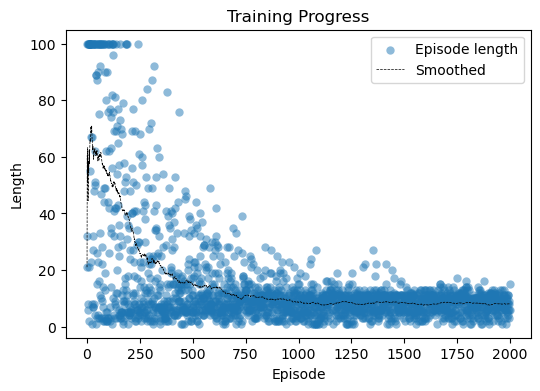

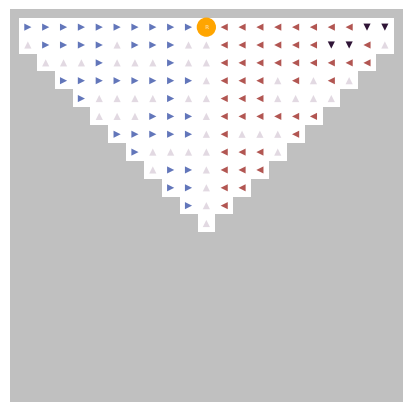

In [102]:
agent.produce_plots(training=True, policy=True)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(14.0, 36.0, 36.0, 14.0)

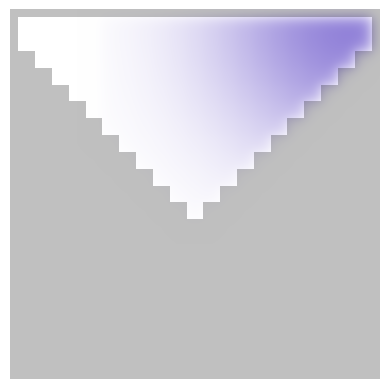

In [105]:
from matplotlib import colors

print(env[:, :, 0])

k1d = signal.windows.gaussian(pk, std=6)
k2d = np.outer(k1d, k1d)

r, c = (pk_hw, (height + pk_hw - 1))
cue_top = r - pk_hw
cue_bottom = r + pk_hw
cue_left = c - pk_hw
cue_right = c + pk_hw

env[cue_top: cue_bottom, cue_left: cue_right, 0] += (env[cue_top: cue_bottom, cue_left: cue_right, -1] * k2d[:cue_bottom - cue_top, :cue_right - cue_left])

cmap_ch0 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:ultramarine"]
)

cmap_ch1 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:magenta"]
)

cmap_wall = cm.binary
cmap_wall.set_under('k', alpha=0)


# Environment 
plt.imshow(1 - env[:, :, -1], clim=[0.1,1.0], cmap=cmap_wall, alpha=0.25, zorder=1)
plt.imshow((cmap_ch0(env[:,:,0]) + cmap_ch1(env[:,:,1]))/2, interpolation='gaussian', zorder=0) 

# Adjust axes 
plt.xlim([(pk//2) - 1, width + pk//2])
plt.ylim([height + pk//2, (pk//2) - 1]) 
plt.axis("off")